In [ ]:
"""
@Josh Boquiren
OTIS Lab MUSC
5.23.2023
"""

"""
Notes:
- populations of interest: Acquisition, CueRein
"""

## Pilot

In [1]:
#import libraries

#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples

from tqdm.notebook import tqdm
tqdm.pandas()

from itertools import product


In [3]:
#initialize directories

population = 'ACQUISITION and REINSTATEMENT'

try:
    user = 'jboqu'
except:
    user = 'OtisLab'
else:
    user = 'OtisLab'
print('User:', user)

basedir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data'%(user)
print('Base directory:', basedir)

acq_earlybasedir = os.path.join(basedir, 'EarlyAcq')
acq_middlebasedir = os.path.join(basedir, 'MidAcq')
acq_latebasedir = os.path.join(basedir, 'LateAcq')
rst_cuedir = os.path.join(basedir, 'CueRein')

results = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\cue-analysis\cue\results'%(user)
print('Results directory:', results)

#cluster list files
acq_early_newlabels = np.load(os.path.join(acq_earlybasedir, 'cluster_list_per_session_Acquisition.npy')) #put clustering files in a folder to loop through
acq_middle_newlabels = np.load(os.path.join(acq_middlebasedir, 'cluster_list_per_session_Acquisition.npy'))
acq_late_newlabels = np.load(os.path.join(acq_latebasedir, 'cluster_list_per_session_Acquisition.npy'))

rst_newlabels = np.load(os.path.join(rst_cuedir, 'cluster_list_per_session_CueDrugTMT.npy'))

#for later plot titles
plot_titles = ['EARLY', 'MIDDLE', 'LATE']
population_title = "ACQ"

#animals of interest
early_animals_of_interest = [
    'CTL1',
    'ER-L1', 'ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_of_interest = [
    'CTL1',

    'ER-L1', #FIXME - only 1 inactive press frame recorded
    'ER-L2',

    'IG-19',

    'LCDD-PGa1', #FIXME - only 1 inactive press frame recorded
    'LCDD-PGa3',
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'LCDD-PGa-T1',
    'LCDD-PGa-T2', #FIXME - only 1 inactive press frame recorded
    'LCDD-PGa-T3',
    'LCDD-PGa-T4',
    'LCDD-PGa-T5',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3'
    ]  
late_animals_of_interest = [
    'CTL1',

    'ER-L1',
    'ER-L2',

    'IG-19',

    'LCDD-PGa1',
    'LCDD-PGa3', 
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'LCDD-PGa-T1',
    'LCDD-PGa-T2',
    'LCDD-PGa-T3',
    'LCDD-PGa-T4',
    'LCDD-PGa-T5',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3' #FIXME
    ]  

cue_animals_of_interest = [
    'CTL1',
    'ER-L1', 'ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]   

User: OtisLab
Base directory: C:\Users\OtisLab\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data
Results directory: C:\Users\OtisLab\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\cue-analysis\cue\results


In [4]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate
print('Frame rate:', framerate)
print('Averaged frame rate:', averagedframerate)

#window size variables
pre_window_size = int(10*framerate)
window_size =  int((pre_window_size*2)+(3*framerate))
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))
print('Prewindow size:', pre_window_size)
print('Window size:', window_size)
print('Postwindow size:', post_window_size)

#set cell tracking
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes
csv_id_for_tracking = 'CUE-DRUG-TMT'

#tracking
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

Frame rate: 8.333325
Averaged frame rate: 8.333325
Prewindow size: 83
Window size: 190
Postwindow size: 107
No Cell Tracking


## Population Analysis

### Preprocessing

In [ ]:
#method for fixing dropped frames
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

#method for fixing assumed frames
def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

#generate behavior data
try:
    assumed_frames = np.load(os.path.join(models, 'assumed_frames.npy'))
    assumed_frame_timestamps = np.load(os.path.join(models, 'assumed_frame_timestamps.npy'))
    print("Loaded behavior data.")
except:
    #load in data
    print('Processing data...')
    behaviordata_noframes = sio.loadmat(r"\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\Spreadsheets\matfile_noframes_3.mat"%(user))
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    #parse desired data
    max_of_eventlog_noframes = max(eventlog_noframes[:,1]) #all rows, second column
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)
    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

    np.save(os.path.join(models, 'assumed_frames'), assumed_frames)
    np.save(os.path.join(models, 'assumed_frame_timestamps'), assumed_frame_timestamps)
    print("Behavior data processed and loaded.")


In [ ]:
#various methods

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2

def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        #print('     e:', e)
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function ipltements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [ ]:
#method for animal analysis
def analyze_single_session(indir, window_size, pre_window_size):    
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        if npyfile[0][0]!='nan':
            npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numneurons = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        if signals2[0][0]!='nan':
            signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        if signals3[0][0]!='nan':
            signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        if signals4[0][0]!='nan':
            signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    
    #pulling data from eventlog
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]  

    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T
    
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1]) 
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]

    seconds_monitored = int(signals.shape[1]/averagedframerate) #seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) #final seconds to be monitored for behavior

    #calculate last fully-monitored active lever press with 2p recording
    if seconds_monitored < seconds_behavior: 
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i]) #FIXME why is this even here?
        activelever=included_trials 
    #combines all presses
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))

    #creating flags
    positive = np.ones(len(activelever))
    negative = np.zeros(len(activelevertimeout))
    flags = np.hstack((positive, negative))

    #array shape error handler
    if activeleverall.shape[0] < 6:
        activeleverall =np.array([])
    if inactiveleverall.shape[0] < 6:
        inactiveleverall = np.array([])

    #method for calculating aligned data
    def calculate_aligneddata_forevent(data, frame_after_event):
        framenumberfor_eventofinterest = framenumberforevent(frame_after_event, frame_timestamps)
        numtrials = framenumberfor_eventofinterest.shape[0] 
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numneurons])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numneurons])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    endindex = tempendindex
                else:
                    endindex = tempendindex
                    prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numneurons))
                    align[i,:,:] = np.nan*np.ones((window_size, numneurons))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))
        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
        return align, align_to_plot, framenumberfor_eventofinterest
    
    # align_activelever_cue, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
    #     calculate_aligneddata_forevent(signalsT, activeleverall)  
    # population_cue = np.nanmean(align_activelever_cue, axis=0).T-1

    # align_activelever_no_cue, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
    #     calculate_aligneddata_forevent(signalsT, activelevertimeout)  
    # population_no_cue = np.nanmean(align_activelever_no_cue, axis=0).T-1

    align_activelever_all, align_to_plot_activelever, framenumberfor_frameafter_activelever = calculate_aligneddata_forevent(signalsT, activeleverall)
    population_data = np.nanmean(align_activelever_all, axis=0).T-1
        
    # return population_cue, population_no_cue, align_activelever_cue, align_activelever_no_cue, framerate, active_flags_df
    return population_data, align_activelever_all, framerate, flags

#### Making file

In [ ]:
#FIXME Testing

trouble_animals = ['LCDD-PGa-T1']
for animal in trouble_animals:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(acq_earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        populationData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
            #analysis parameters
            os.path.join(acq_earlybasedir, animal, fov), 
            window_size, 
            pre_window_size
            )
        print(flags)
        print(alignedActiveLeverCueAll.shape)
        print(populationData.shape)
        # np.save(os.path.join(earlybasedir, animal, fov, 'cuePopulation.npy'), cuePopulation)
        # np.save(os.path.join(earlybasedir, animal, fov, 'noCuePopulation.npy'), noCuePopulation)
        # np.save(os.path.join(earlybasedir, animal, fov, 'alignedActiveLeverCue.npy'), alignedActiveLeverCue)
        # np.save(os.path.join(earlybasedir, animal, fov, 'alignedActiveLeverNoCue.npy'), alignedActiveLeverNoCue)
        # cueFlags.to_csv(os.path.join(earlybasedir, animal, fov, 'active_flags.csv'), index=False)

In [ ]:
#Early population
excluded = []
for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(acq_earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            signalsData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
                #analysis parameters
                os.path.join(acq_earlybasedir, animal, fov), 
                window_size, 
                pre_window_size
                )
            np.save(os.path.join(acq_earlybasedir, animal, fov, 'signalsData.npy'), signalsData)
            np.save(os.path.join(acq_earlybasedir, animal, fov, 'alignedActiveLeverCueData.npy'), alignedActiveLeverCueAll)
            np.save(os.path.join(acq_earlybasedir, animal, fov, 'classificationFlags.npy'), flags)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('Early excluded animals:', excluded)

In [ ]:
#Middle population
excluded = []
for animal in middle_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(acq_middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            signalsData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
                #analysis parameters
                os.path.join(acq_middlebasedir, animal, fov), 
                window_size, 
                pre_window_size
                )
            np.save(os.path.join(acq_middlebasedir, animal, fov, 'signalsData.npy'), signalsData)
            np.save(os.path.join(acq_middlebasedir, animal, fov, 'alignedActiveLeverCueData.npy'), alignedActiveLeverCueAll)
            np.save(os.path.join(acq_middlebasedir, animal, fov, 'classificationFlags.npy'), flags)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('Middle excluded animals:', excluded)

In [ ]:
#Late population
excluded = []
for animal in late_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(acq_latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            signalsData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
                #analysis parameters
                os.path.join(acq_latebasedir, animal, fov), 
                window_size, 
                pre_window_size
                )
            np.save(os.path.join(acq_latebasedir, animal, fov, 'signalsData.npy'), signalsData)
            np.save(os.path.join(acq_latebasedir, animal, fov, 'alignedActiveLeverCueData.npy'), alignedActiveLeverCueAll)
            np.save(os.path.join(acq_latebasedir, animal, fov, 'classificationFlags.npy'), flags)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('Late excluded animals:', excluded)

In [ ]:
#Cue Rein
excluded = []
for animal in cue_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(rst_cuedir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            signalsData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
                #analysis parameters
                os.path.join(rst_cuedir, animal, fov), 
                window_size, 
                pre_window_size
                )
            np.save(os.path.join(rst_cuedir, animal, fov, 'signalsData.npy'), signalsData)
            np.save(os.path.join(rst_cuedir, animal, fov, 'alignedActiveLeverCueData.npy'), alignedActiveLeverCueAll)
            np.save(os.path.join(rst_cuedir, animal, fov, 'classificationFlags.npy'), flags)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('Early excluded animals:', excluded)

### Stacking data

In [ ]:
#method for stacking data
def stack_data(indir, animals_of_interest, window, signals_file, aligned_levers_file):
    temp_data = np.nan*np.ones((1, window))
    for animal in animals_of_interest:
            FOVs = next(os.walk(os.path.join(indir, animal)))[1]
            for fov in sorted(FOVs):
                #load in data
                signal_data = np.load(os.path.join(indir, animal, fov, signals_file))
                lever_data = np.load(os.path.join(indir, animal, fov, aligned_levers_file))
                #stack data
                temp_data = np.vstack((temp_data, signal_data))
    data = temp_data[1:,:]
    return(data, lever_data)

In [ ]:
#method for matching neurons to clusters based on criteria
def find_indexes(indir, sub_animals_of_interest_array, original_full_stack, signal_file, cluster_labels_file):
    indexes = []
    for animal in sub_animals_of_interest_array:
        FOVs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(FOVs):
            signal_data = np.load(os.path.join(indir, animal, fov, signal_file))
            for neuron in range(len(signal_data)):
                for row in range(len(original_full_stack)):
                    if np.equal(signal_data[neuron], original_full_stack[row])[0]==True:
                        indexes.append({'Animal': animal, 'Stack index': row, 'Cluster': cluster_labels_file[row]})
    indexes = pd.DataFrame(indexes)
    return(indexes)

#### Cue data

Cue-all

In [ ]:
#stacking early data

temp_early_cue, early_lever_cue = stack_data(acq_earlybasedir, early_animals_of_interest, window_size, 'signalsData.npy','alignedActiveLeverCueData.npy')

#num neurons
numneurons_early_cue = temp_early_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_cue[:,baselinefirstframe:baselinelastframe], axis=1)
early_cue = temp_early_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_early_cue = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_cue_mean = np.nanmean(early_cue, axis=0)

print('Cue population shape:', early_cue.shape)
print('Early labels shape:', acq_early_newlabels.shape)

In [ ]:
#stacking middle data

temp_middle_cue, middle_lever_cue = stack_data(acq_middlebasedir, middle_animals_of_interest, window_size, 'signalsData.npy','alignedActiveLeverCueData.npy')

#num neurons
numneurons_middle_cue = temp_middle_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_cue[:,baselinefirstframe:baselinelastframe], axis=1)
middle_cue = temp_middle_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_middle_cue = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
middle_cue_mean = np.nanmean(middle_cue, axis=0)

print('Cue population shape:', middle_cue.shape)

In [ ]:
#stacking late data

temp_late_cue, late_lever_cues = stack_data(acq_latebasedir, late_animals_of_interest, window_size, 'signalsData.npy','alignedActiveLeverCueData.npy')

#num neurons
numneurons_late_cue = temp_late_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_late_cue[:,baselinefirstframe:baselinelastframe], axis=1)
late_cue = temp_late_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_late_cue = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
late_cue_mean = np.nanmean(late_cue, axis=0)

print('Cue population shape:', late_cue.shape)

Cue within-session division

In [ ]:
early_p1 = early_cue[:int(len(early_cue)/2)]
early_p2 = early_cue[int(len(early_cue)/2):]
print('Part 1 shape:', early_p1.shape)
print('Part 2 shape:', early_p2.shape)

temp1 = np.nanmean(early_p1[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
temp2 = np.nanmean(early_p2[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)

early_p1_sort = np.argsort(temp1)[::-1]
early_p2_sort = np.argsort(temp2)[::-1]

early_p1_orig_sort = np.argsort(sortresponse_early_cue[:int(len(sortresponse_early_cue)/2)])[::-1]
early_p2_orig_sort = np.argsort(sortresponse_early_cue[int(len(sortresponse_early_cue)/2):])[::-1]

early_p1_mean = np.nanmean(early_p1, axis=0)
early_p2_mean = np.nanmean(early_p2, axis=0)

In [ ]:
middle_p1 = middle_cue[:int(len(middle_cue)/2)]
middle_p2 = middle_cue[int(len(middle_cue)/2):]
print('Part 1 shape:', middle_p1.shape)
print('Part 2 shape:', middle_p2.shape)

temp1 = np.nanmean(middle_p1[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
temp2 = np.nanmean(middle_p2[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)

middle_p1_sort = np.argsort(temp1)[::-1]
middle_p2_sort = np.argsort(temp2)[::-1]

middle_p1_orig_sort = np.argsort(sortresponse_middle_cue[:int(len(sortresponse_middle_cue)/2)])[::-1]
middle_p2_orig_sort = np.argsort(sortresponse_middle_cue[int(len(sortresponse_middle_cue)/2):])[::-1]

middle_p1_mean = np.nanmean(middle_p1, axis=0)
middle_p2_mean = np.nanmean(middle_p2, axis=0)

In [ ]:
late_p1 = late_cue[:int(len(late_cue)/2)]
late_p2 = late_cue[int(len(late_cue)/2):]
print('Part 1 shape:', late_p1.shape)
print('Part 2 shape:', late_p2.shape)

temp1 = np.nanmean(late_p1[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
temp2 = np.nanmean(late_p2[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)

late_p1_sort = np.argsort(temp1)[::-1]
late_p2_sort = np.argsort(temp2)[::-1]

late_p1_orig_sort = np.argsort(sortresponse_late_cue[:int(len(sortresponse_late_cue)/2)])[::-1]
late_p2_orig_sort = np.argsort(sortresponse_late_cue[int(len(sortresponse_late_cue)/2):])[::-1]

late_p1_mean = np.nanmean(late_p1, axis=0)
late_p2_mean = np.nanmean(late_p2, axis=0)

#### No-cue data

In [ ]:
#stacking early data

temp_early_no_cue, early_lever_no_cue = stack_data(acq_earlybasedir, early_animals_of_interest, window_size, 'noCuePopulation.npy','alignedActiveLeverNoCue.npy')

#num neurons
numneurons_early_no_cue = temp_early_no_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_no_cue[:,baselinefirstframe:baselinelastframe], axis=1)
early_no_cue = temp_early_no_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_no_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_early_no_cue = np.argsort(tempresponse)[::-1]

#calculating the mean
early_no_cue_mean = np.nanmean(early_no_cue, axis=0)
print(early_no_cue.shape)

In [ ]:
#stacking middle data

temp_middle_no_cue, middle_lever_no_cue = stack_data(acq_middlebasedir, middle_animals_of_interest, window_size, 'noCuePopulation.npy','alignedActiveLeverNoCue.npy')

#num neurons
numneurons_middle_no_cue = temp_middle_no_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_no_cue[:,baselinefirstframe:baselinelastframe], axis=1)
middle_no_cue = temp_middle_no_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_no_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_middle_no_cue = np.argsort(tempresponse)[::-1]

#calculating the mean
middle_no_cue_mean = np.nanmean(middle_no_cue, axis=0)

print('No-cue population shape:', middle_no_cue.shape)

In [ ]:
#stacking late data

temp_late_no_cue, late_lever_no_cue = stack_data(acq_latebasedir, late_animals_of_interest, window_size, 'noCuePopulation.npy','alignedActiveLeverNoCue.npy')

#num neurons
numneurons_late_no_cue = temp_late_no_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_late_no_cue[:,baselinefirstframe:baselinelastframe], axis=1)
late_no_cue = temp_late_no_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_no_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_late_no_cue = np.argsort(tempresponse)[::-1]

#calculating the mean
late_no_cue_mean = np.nanmean(late_no_cue, axis=0)

print('No-cue population shape:', late_no_cue.shape)

In [ ]:
#normalizing data
early_diff = (early_cue - early_no_cue)
middle_diff = (middle_cue - middle_no_cue)
late_diff = (late_cue - late_no_cue)

early_diff_mean = np.mean(early_diff, axis=0)
middle_diff_mean = np.mean(middle_diff, axis=0)
late_diff_mean = np.mean(late_diff, axis=0)

#### CueRein

In [ ]:
rst_dir = os.path.join(basedir, 'CueRein')

rst_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  

rst_cue, rst_cue_lever = stack_data(rst_dir, rst_animals_of_interest, window_size, 'cuePopulation.npy','alignedActiveLeverCueData.npy')
rst_no_cue, rst_no_cue_lever = stack_data(rst_dir, rst_animals_of_interest, window_size, 'noCuePopulation.npy','alignedActiveLeverNoCue.npy')

#num neurons cue
numneurons_rst_cue = rst_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(rst_cue[:,baselinefirstframe:baselinelastframe], axis=1)
rst_cue = rst_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(rst_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_rst_cue = np.argsort(tempresponse)[::-1]

#calculating the mean
rst_cue_mean = np.nanmean(rst_cue, axis=0)

print('Cue population shape:', rst_cue.shape)


#num neurons no-cue
numneurons_rst_no_cue = rst_no_cue.shape[0]

#calculating population data - baseline
baseline = np.mean(rst_no_cue[:,baselinefirstframe:baselinelastframe], axis=1)
rst_no_cue = rst_no_cue - baseline[:,None]

#sorting data
tempresponse = np.nanmean(rst_no_cue[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_rst_no_cue = np.argsort(tempresponse)[::-1]

#calculating the mean
rst_no_cue_mean = np.nanmean(rst_no_cue, axis=0)

print('No-cue population shape:', rst_no_cue.shape)

rst_diff = rst_cue - rst_no_cue
rst_diff_mean = np.mean(rst_diff, axis=0)

In [ ]:
rst_p1 = rst_cue[:int(len(rst_cue)/2)]
rst_p2 = rst_cue[int(len(rst_cue)/2):]
print('Part 1 shape:', rst_p1.shape)
print('Part 2 shape:', rst_p2.shape)

temp1 = np.nanmean(rst_p1[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
temp2 = np.nanmean(rst_p2[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)

rst_p1_sort = np.argsort(temp1)[::-1]
rst_p2_sort = np.argsort(temp2)[::-1]

rst_p1_orig_sort = np.argsort(sortresponse_rst_cue[:int(len(sortresponse_rst_cue)/2)])[::-1]
rst_p2_orig_sort = np.argsort(sortresponse_rst_cue[int(len(sortresponse_rst_cue)/2):])[::-1]

rst_p1_mean = np.nanmean(rst_p1, axis=0)
rst_p2_mean = np.nanmean(rst_p2, axis=0)

### Plots

In [ ]:
#filter out the NaN values
def filter_NAN(processed_data, windowsize, prewindowsize, framerate):
        filtered_stack = np.nan*np.ones((1, windowsize))
        for row in processed_data:
                if np.isfinite(row[0]):
                        filtered_stack = np.vstack((filtered_stack, row))
        filtered_stack = filtered_stack[1:,:]
        response = np.nanmean(filtered_stack[:,prewindowsize-(1*int(framerate)):prewindowsize+1*int(framerate)], axis=1)
        sortresponse = np.argsort(response)[::-1]
        return(filtered_stack, sortresponse)

#### Cue vs No-cue

In [ ]:
#plot

# initialize the plot
fig, axs = plt.subplots(3, 4, figsize=(15, 11)) #rows x columns, width x height
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early cue plots
ax = axs[0, 0] #[row, col]

# heatmap
hm = sns.heatmap(early_cue[sortresponse_early_cue,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_cue], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[2, 0]
ax.plot(early_cue_mean)
ax.plot(early_no_cue_mean)
ax.plot(early_diff_mean, color='k', linestyle=':')
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Cue', 'No cue', 'Difference'])

# early no-cue plots
ax = axs[1, 0]

# heatmap
hm = sns.heatmap(early_no_cue[sortresponse_early_no_cue,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-NO CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % early_no_cue.shape[0], fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_no_cue], '--', linewidth=1.5, color='white')

# middle cue plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(middle_cue[sortresponse_middle_cue, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_cue], '--', linewidth=1.5, color='white')

# line plot
ax = axs[2, 1]
ax.plot(middle_cue_mean)
ax.plot(middle_no_cue_mean)
ax.plot(middle_diff_mean, color='k', linestyle=':')
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Cue', 'No cue', 'Difference'])

# middle no-cue plots
ax = axs[1, 1]

# heatmap
hm = sns.heatmap(middle_no_cue[sortresponse_middle_no_cue,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-NO CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % middle_no_cue.shape[0], fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_no_cue], '--', linewidth=1.5, color='white')

# late cue plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(late_cue[sortresponse_late_cue,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_late_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_cue], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[2, 2]
ax.plot(late_cue_mean)
ax.plot(late_no_cue_mean)
ax.plot(late_diff_mean, color='k', linestyle=':')
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Cue', 'No cue','Difference'])

# late no-cue plots
ax = axs[1, 2]

# heatmap
hm = sns.heatmap(late_no_cue[sortresponse_late_no_cue,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-NO CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % late_no_cue.shape[0], fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_no_cue], '--', linewidth=1.5, color='white')





ax = axs[0,3]
# heatmap
hm = sns.heatmap(rst_cue[sortresponse_rst_cue,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title("CUE REIN-CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_rst_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_rst_cue], '--', linewidth=1.5, color='white')

ax = axs[1,3]
# heatmap
hm = sns.heatmap(rst_no_cue[sortresponse_rst_no_cue,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title("CUE REIN-NO CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_rst_no_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_rst_no_cue], '--', linewidth=1.5, color='white')

ax = axs[2,3]
ax.plot(rst_cue_mean)
ax.plot(rst_no_cue_mean)
ax.plot(rst_diff_mean, color='k', linestyle=':')
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Cue', 'No cue','Difference'])

In [ ]:
fig.savefig(os.path.join(results, 'population/PFC-HeroinSA_cue-analysis_population.pdf'), format='PDF')

#### Within-session

In [ ]:
#plot

# initialize the plot
fig, axs = plt.subplots(3, 4, figsize=(15, 11)) #rows x columns, width x height
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

#Early-early cue
ax = axs[0, 0] #[row, col] 

# heatmap
hm = sns.heatmap(early_p1[early_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title('ACQ Early: Pt. 1', fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_cue], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[2, 0]
ax.plot(early_p1_mean)
ax.plot(early_p2_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Pt. 1', 'Pt. 2'])

#Late-early cue
ax = axs[1, 0]

# heatmap
hm = sns.heatmap(early_p2[early_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title('ACQ Early: Pt. 2', fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % early_cue.shape[0], fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_cue], '--', linewidth=1.5, color='white')

# middle cue plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(middle_p1[middle_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title('ACQ Middle: Pt. 1', fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_cue], '--', linewidth=1.5, color='white')

# line plot
ax = axs[2, 1]
ax.plot(middle_p1_mean)
ax.plot(middle_p2_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Pt. 1', 'Pt. 2'])

# middle no-cue plots
ax = axs[1, 1]

# heatmap
hm = sns.heatmap(middle_p2[middle_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title('ACQ Middle: Pt. 2', fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % middle_cue.shape[0], fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_cue], '--', linewidth=1.5, color='white')

# late cue plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(late_p1[late_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title('ACQ Late: Pt. 1', fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_late_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_cue], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[2, 2]
ax.plot(late_p1_mean)
ax.plot(late_p2_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Pt. 1', 'Pt. 2'])

# late no-cue plots
ax = axs[1, 2]

# heatmap
hm = sns.heatmap(late_p2[late_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title('ACQ Late: Pt. 2', fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % late_cue.shape[0], fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_cue], '--', linewidth=1.5, color='white')


ax = axs[0,3]
# heatmap
hm = sns.heatmap(rst_p1[rst_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title("CueRein Pt. 1", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_rst_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_rst_cue], '--', linewidth=1.5, color='white')

ax = axs[1,3]
# heatmap
hm = sns.heatmap(rst_p2[rst_p1_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title("CueRein Pt. 2", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_rst_cue, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_rst_cue], '--', linewidth=1.5, color='white')

ax = axs[2,3]
ax.plot(rst_p1_mean)
ax.plot(rst_p2_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Pt. 1', 'Pt. 2'])

## Cluster Analysis

In [ ]:
#import libraries

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
from scipy import interpolate
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

import matplotlib.pyplot as plt

### Cue-all

#### Heatmaps

In [ ]:
#cluster heatmaps for cue

sessions = [early_diff, middle_diff, late_diff, rst_diff] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for cluster, cluster in enumerate(uniquelabels):
    sortwindow[cluster] = {}
    if cluster == 0:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 1:
        sortwindow[cluster] = [infusionframe+int(1*framerate), -1]
    if cluster == 2:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 3:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1
cmin = -.1

fig, axs = plt.subplots(4,len(uniquelabels), figsize=(11,11))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    early = early_diff[np.where(acq_early_newlabels==cluster)[0],:]
    middle = middle_diff[np.where(acq_middle_newlabels==cluster)[0],:]
    late = late_diff[np.where(acq_late_newlabels==cluster)[0],:]
    rst = rst_diff[np.where(rst_newlabels==cluster)[0],:]

    #num neurons
    early_n = early.shape[0]
    middle_n = middle.shape[0]
    late_n = late.shape[0]
    rst_n = rst.shape[0]

    #sort response
    early_sort = np.argsort(np.mean(early[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    middle_sort = np.argsort(np.mean(middle[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    late_sort = np.argsort(np.mean(late[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    rst_sort = np.argsort(np.mean(rst[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    
    #heatmaps
    early_hm = sns.heatmap(
                    early[early_sort],
                    ax=axs[0, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[0, cluster].grid(False)
    axs[0, cluster].set_xticks([])
    axs[0, cluster].tick_params(width=0.5)    
    axs[0, cluster].set_xticklabels([])
    axs[0, cluster].set_yticks([])
    axs[0, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

    middle_hm = sns.heatmap(
                    middle[middle_sort],
                    ax=axs[1, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[1, cluster].grid(False)
    axs[1, cluster].set_xticks([])
    axs[1, cluster].tick_params(width=0.5)    
    axs[1, cluster].set_xticklabels([])
    axs[1, cluster].set_yticks([])
    axs[1, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    late_hm = sns.heatmap(
                    late[late_sort],
                    ax=axs[2, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[2, cluster].grid(False)
    axs[2, cluster].set_xticks([])
    axs[2, cluster].tick_params(width=0.5)    
    axs[2, cluster].set_xticklabels([])
    axs[2, cluster].set_yticks([])
    axs[2, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
    
    rst_hm = sns.heatmap(
                    rst[rst_sort],
                    ax=axs[3,cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[3, cluster].grid(False)
    axs[3, cluster].set_xticks([])
    axs[3, cluster].tick_params(width=0.5)    
    axs[3, cluster].set_xticklabels([])
    axs[3, cluster].set_yticks([])
    axs[3, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    axs[0, 0].set_ylabel('Early ACQ')
    axs[1, 0].set_ylabel('Middle ACQ')
    axs[2, 0].set_ylabel('Late ACQ')
    axs[3, 0].set_ylabel('CueRein')

    # axs[0, 0].set_ylabel('Early ACQ, N = %s'%(early_n))
    # axs[1, 0].set_ylabel('Middle ACQ, N = %s'%(middle_n))
    # axs[2, 0].set_ylabel('Late ACQ, N = %s'%(late_n))
    # axs[3, 0].set_ylabel('CueRein, N = %s'%(rst_n))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12, horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



In [ ]:
fig.savefig(os.path.join(results, 'clusters/PFC-HeroinSA_cue-analysis_clusters-heatmaps.pdf'), format='PDF')

#### Polylines

In [ ]:
#cluster line plots for differences

#vertical plot
# fig, axs = plt.subplots(len(uniquelabels), 1, figsize=(8, 20))

#horizontal plot
fig, axs = plt.subplots(1,len(uniquelabels), figsize=(18, 5))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    early = early_diff[np.where(acq_early_newlabels==cluster)[0],:]
    middle = middle_diff[np.where(acq_middle_newlabels==cluster)[0],:]
    late = late_diff[np.where(acq_late_newlabels==cluster)[0],:]
    if cluster == 0:
        rst = rst_diff[np.where(rst_newlabels==3)[0],:]
    if cluster == 1:
        rst = rst_diff[np.where(rst_newlabels==0)[0],:]
    if cluster == 2:
        rst = rst_diff[np.where(rst_newlabels==1)[0],:]
    if cluster == 3:
        rst = rst_diff[np.where(rst_newlabels==2)[0],:]

    #means for polylines
    early_m = np.mean(early, axis=0)
    middle_m = np.mean(middle, axis=0)
    late_m = np.mean(late, axis=0)
    rst_m = np.mean(rst, axis=0)

    #num neurons
    early_n = early.shape[0]
    middle_n = middle.shape[0]
    late_n = late.shape[0]
    rst_n = rst.shape[0]
    
    #plot means
    axs[cluster].plot(early_m, color='blue', linewidth=.5)
    axs[cluster].plot(middle_m, color='grey', linewidth=.5)
    axs[cluster].plot(late_m, color='red')
    axs[cluster].plot(rst_m, color='black')

#annotations
    axs[cluster].legend(['Early ACQ, N: %s'%(early_n), 
                         'Middle ACQ, N: %s'%(middle_n), 
                         'Late ACQ, N: %s'%(late_n), 
                         'Cue RST, N: %s'%(rst_n)], 
                         fontsize=8)
    axs[cluster].set_title('Cluster: %s'%(cluster+1))
    axs[cluster].grid(False)
    axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_yticks([])
    axs[cluster].set(ylim=(-.05, .05))    
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


In [ ]:
#cluster line plots for cue

#vertical plot
# fig, axs = plt.subplots(len(uniquelabels), 1, figsize=(8, 20))

#horizontal plot
fig, axs = plt.subplots(1,len(uniquelabels), figsize=(18, 5))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    early = early_cue[np.where(acq_early_newlabels==cluster)[0],:]
    middle = middle_cue[np.where(acq_middle_newlabels==cluster)[0],:]
    late = late_cue[np.where(acq_late_newlabels==cluster)[0],:]
    if cluster == 0:
        rst = rst_cue[np.where(rst_newlabels==3)[0],:]
    if cluster == 1:
        rst = rst_cue[np.where(rst_newlabels==0)[0],:]
    if cluster == 2:
        rst = rst_cue[np.where(rst_newlabels==1)[0],:]
    if cluster == 3:
        rst = rst_cue[np.where(rst_newlabels==2)[0],:]

    #means for polylines
    early_m = np.mean(early, axis=0)
    middle_m = np.mean(middle, axis=0)
    late_m = np.mean(late, axis=0)
    rst_m = np.mean(rst, axis=0)

    #num neurons
    early_n = early.shape[0]
    middle_n = middle.shape[0]
    late_n = late.shape[0]
    rst_n = rst.shape[0]
    
    #plot means
    axs[cluster].plot(early_m, color='blue', linewidth=.5)
    axs[cluster].plot(middle_m, color='grey', linewidth=.5)
    axs[cluster].plot(late_m, color='red')
    axs[cluster].plot(rst_m, color='black')

#annotations
    axs[cluster].legend(['Early ACQ, N: %s'%(early_n), 
                         'Middle ACQ, N: %s'%(middle_n), 
                         'Late ACQ, N: %s'%(late_n), 
                         'Cue RST, N: %s'%(rst_n)], 
                         fontsize=8)
    axs[cluster].set_title('Cluster: %s'%(cluster+1))
    axs[cluster].grid(False)
    axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_yticks([])
    axs[cluster].set(ylim=(-.2, .2))    
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


In [ ]:
#cluster line plots for no-cue

#vertical plot
# fig, axs = plt.subplots(len(uniquelabels), 1, figsize=(8, 20))

#horizontal plot
fig, axs = plt.subplots(1,len(uniquelabels), figsize=(18, 5))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    early = early_no_cue[np.where(acq_early_newlabels==cluster)[0],:]
    middle = middle_no_cue[np.where(acq_middle_newlabels==cluster)[0],:]
    late = late_no_cue[np.where(acq_late_newlabels==cluster)[0],:]
    if cluster == 0:
        rst = rst_no_cue[np.where(rst_newlabels==3)[0],:]
    if cluster == 1:
        rst = rst_no_cue[np.where(rst_newlabels==0)[0],:]
    if cluster == 2:
        rst = rst_no_cue[np.where(rst_newlabels==1)[0],:]
    if cluster == 3:
        rst = rst_no_cue[np.where(rst_newlabels==2)[0],:]

    #means for polylines
    early_m = np.mean(early, axis=0)
    middle_m = np.mean(middle, axis=0)
    late_m = np.mean(late, axis=0)
    rst_m = np.mean(rst, axis=0)

    #num neurons
    early_n = early.shape[0]
    middle_n = middle.shape[0]
    late_n = late.shape[0]
    rst_n = rst.shape[0]
    
    #plot means
    axs[cluster].plot(early_m, color='blue', linewidth=.5)
    axs[cluster].plot(middle_m, color='grey', linewidth=.5)
    axs[cluster].plot(late_m, color='red')
    axs[cluster].plot(rst_m, color='black')

#annotations
    axs[cluster].legend(['Early ACQ, N: %s'%(early_n), 
                         'Middle ACQ, N: %s'%(middle_n), 
                         'Late ACQ, N: %s'%(late_n), 
                         'Cue RST, N: %s'%(rst_n)], 
                         fontsize=8)
    axs[cluster].set_title('Cluster: %s'%(cluster+1))
    axs[cluster].grid(False)
    axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_yticks([])
    axs[cluster].set(ylim=(-.2, .2))    
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


In [ ]:
fig, axs = plt.subplots(4,len(uniquelabels), figsize=(15, 15))

for c, cluster in enumerate(uniquelabels):

    early_m_cue = np.mean(early_cue[np.where(acq_early_newlabels==cluster)[0],:], axis=0)
    middle_m_cue = np.mean(middle_cue[np.where(acq_middle_newlabels==cluster)[0],:], axis=0)
    late_m_cue = np.mean(late_cue[np.where(acq_late_newlabels==cluster)[0],:], axis=0)
    rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==3)[0],:], axis=0)

    early_m_no_cue = np.mean(early_no_cue[np.where(acq_early_newlabels==cluster)[0],:], axis=0)
    middle_m_no_cue = np.mean(middle_no_cue[np.where(acq_middle_newlabels==cluster)[0],:], axis=0)
    late_m_no_cue = np.mean(late_no_cue[np.where(acq_late_newlabels==cluster)[0],:], axis=0)

    early_m_diff = np.mean(early_diff[np.where(acq_early_newlabels==cluster)[0],:], axis=0)
    middle_m_diff = np.mean(middle_diff[np.where(acq_middle_newlabels==cluster)[0],:], axis=0)
    late_m_diff = np.mean(late_diff[np.where(acq_late_newlabels==cluster)[0],:], axis=0)

    if cluster == 0:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==3)[0],:], axis=0)
        rst_m_no_cue = np.mean(rst_no_cue[np.where(rst_newlabels==3)[0],:], axis=0)
        rst_m_diff = np.mean(rst_diff[np.where(rst_newlabels==3)[0],:], axis=0)
    elif cluster == 1:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==0)[0],:], axis=0)
        rst_m_no_cue = np.mean(rst_no_cue[np.where(rst_newlabels==0)[0],:], axis=0)
        rst_m_diff =  np.mean(rst_diff[np.where(rst_newlabels==0)[0],:], axis=0)
    elif cluster == 2:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==1)[0],:], axis=0)
        rst_m_no_cue = np.mean(rst_no_cue[np.where(rst_newlabels==1)[0],:], axis=0)
        rst_m_diff =  np.mean(rst_diff[np.where(rst_newlabels==1)[0],:], axis=0)
    elif cluster == 3:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==2)[0],:], axis=0)
        rst_m_no_cue = np.mean(rst_no_cue[np.where(rst_newlabels==2)[0],:], axis=0)
        rst_m_diff =  np.mean(rst_diff[np.where(rst_newlabels==2)[0],:], axis=0)

    axs[0, c].plot(early_m_cue)
    axs[0, c].plot(early_m_no_cue)
    axs[0, c].plot(early_m_diff, color='k', alpha=.7, linewidth=.8)
    axs[0, c].legend(['Cue', 'No cue', 'Difference'])

    axs[1, c].plot(middle_m_cue)
    axs[1, c].plot(middle_m_no_cue)
    axs[1, c].plot(middle_m_diff, color='k', alpha=.7, linewidth=.8)
    axs[1, c].legend(['Cue', 'No cue', 'Difference'])

    axs[2, c].plot(late_m_cue)
    axs[2, c].plot(late_m_no_cue)
    axs[2, c].plot(late_m_diff, color='k', alpha=.7, linewidth=.8)
    axs[2, c].legend(['Cue', 'No cue', 'Difference'])

    axs[3, c].plot(rst_m_cue)
    axs[3, c].plot(rst_m_no_cue)
    axs[3, c].plot(rst_m_diff, color='k', alpha=.7, linewidth=.8)
    axs[3, c].legend(['Cue', 'No cue', 'Difference'])

    axs[0,c].set_title('Cluster: %s'%(c+1))

    for i in range(4):
        axs[i,c].grid(False)
        axs[i,c].set_xticks([])
        axs[i,c].tick_params(width=0.5)    
        axs[i,c].set_yticks([])
        axs[i,c].set(ylim=(-.15, .15))    
        axs[i,c].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[i,c].axhline(0, linestyle='--', color='k', linewidth=0.5)

axs[0,0].set_ylabel('Early ACQ')
axs[1,0].set_ylabel('Middle ACQ')
axs[2,0].set_ylabel('Late ACQ')
axs[3,0].set_ylabel('Cue RST')

In [ ]:
fig.savefig(os.path.join(results, 'clusters/PFC-HeroinSA_cue-analysis_clusters-polylines.pdf'), format='PDF')

### Within-session

#### Heatmaps

In [ ]:
#cluster heatmaps for cue

sessions = [early_p1, middle_p1, late_p1, rst_p1] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for cluster, cluster in enumerate(uniquelabels):
    sortwindow[cluster] = {}
    if cluster == 0:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 1:
        sortwindow[cluster] = [infusionframe+int(1*framerate), -1]
    if cluster == 2:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 3:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1
cmin = -.1

fig, axs = plt.subplots(4,len(uniquelabels), figsize=(11,11))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    early1 = early_p1[np.where(acq_early_newlabels[:int(len(acq_early_newlabels)/2)]==cluster)[0],:]
    middle1 = middle_p1[np.where(acq_middle_newlabels[:int(len(acq_middle_newlabels)/2)]==cluster)[0],:]
    late1 = late_p1[np.where(acq_late_newlabels[:int(len(acq_late_newlabels)/2)]==cluster)[0],:]
    if cluster == 0:
        rst1 = rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==3)[0],:]
    elif cluster == 1:
        rst1 = rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==0)[0],:]
    elif cluster == 2:
        rst1 = rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==1)[0],:]
    else:
        rst1 = rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==2)[0],:]

    #num neurons
    early_n = early1.shape[0]
    middle_n = middle1.shape[0]
    late_n = late1.shape[0]
    rst_n = rst1.shape[0]

    #sort response
    early_sort = np.argsort(np.mean(early1[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    middle_sort = np.argsort(np.mean(middle1[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    late_sort = np.argsort(np.mean(late1[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    rst_sort = np.argsort(np.mean(rst1[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    
    #heatmaps
    early_hm = sns.heatmap(
                    early1[early_sort],
                    ax=axs[0, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[0, cluster].grid(False)
    axs[0, cluster].set_xticks([])
    axs[0, cluster].tick_params(width=0.5)    
    axs[0, cluster].set_xticklabels([])
    axs[0, cluster].set_yticks([])
    axs[0, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

    middle_hm = sns.heatmap(
                    middle1[middle_sort],
                    ax=axs[1, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[1, cluster].grid(False)
    axs[1, cluster].set_xticks([])
    axs[1, cluster].tick_params(width=0.5)    
    axs[1, cluster].set_xticklabels([])
    axs[1, cluster].set_yticks([])
    axs[1, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    late_hm = sns.heatmap(
                    late1[late_sort],
                    ax=axs[2, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[2, cluster].grid(False)
    axs[2, cluster].set_xticks([])
    axs[2, cluster].tick_params(width=0.5)    
    axs[2, cluster].set_xticklabels([])
    axs[2, cluster].set_yticks([])
    axs[2, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
    
    rst_hm = sns.heatmap(
                    rst1[rst_sort],
                    ax=axs[3,cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[3, cluster].grid(False)
    axs[3, cluster].set_xticks([])
    axs[3, cluster].tick_params(width=0.5)    
    axs[3, cluster].set_xticklabels([])
    axs[3, cluster].set_yticks([])
    axs[3, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    axs[0, 0].set_ylabel('Early ACQ')
    axs[1, 0].set_ylabel('Middle ACQ')
    axs[2, 0].set_ylabel('Late ACQ')
    axs[3, 0].set_ylabel('CueRein')


fig.text(0.5, 0.05, 'Time (sec)', fontsize=12, horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



In [ ]:
#cluster heatmaps for cue

sessions = [early_p2, middle_p2, late_p2, rst_p2] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for cluster, cluster in enumerate(uniquelabels):
    sortwindow[cluster] = {}
    if cluster == 0:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 1:
        sortwindow[cluster] = [infusionframe+int(1*framerate), -1]
    if cluster == 2:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 3:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1
cmin = -.1

fig, axs = plt.subplots(4,len(uniquelabels), figsize=(11,11))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    early2 = early_p2[np.where(acq_early_newlabels[int(len(acq_early_newlabels)/2):]==cluster)[0],:]
    middle2 = middle_p2[np.where(acq_middle_newlabels[int(len(acq_middle_newlabels)/2):]==cluster)[0],:]
    late2 = late_p2[np.where(acq_late_newlabels[int(len(acq_late_newlabels)/2):]==cluster)[0],:]
    if cluster == 0:
        rst2 = rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==3)[0],:]
    elif cluster == 1:
        rst2 = rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==0)[0],:]
    elif cluster == 2:
        rst2 = rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==1)[0],:]
    else:
        rst2 = rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==2)[0],:]

    #num neurons
    early_n = early2.shape[0]
    middle_n = middle2.shape[0]
    late_n = late2.shape[0]
    rst_n = rst2.shape[0]

    #sort response
    early_sort = np.argsort(np.mean(early2[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    middle_sort = np.argsort(np.mean(middle2[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    late_sort = np.argsort(np.mean(late2[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    rst_sort = np.argsort(np.mean(rst2[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    
    #heatmaps
    early_hm = sns.heatmap(
                    early2[early_sort],
                    ax=axs[0, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[0, cluster].grid(False)
    axs[0, cluster].set_xticks([])
    axs[0, cluster].tick_params(width=0.5)    
    axs[0, cluster].set_xticklabels([])
    axs[0, cluster].set_yticks([])
    axs[0, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

    middle_hm = sns.heatmap(
                    middle2[middle_sort],
                    ax=axs[1, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[1, cluster].grid(False)
    axs[1, cluster].set_xticks([])
    axs[1, cluster].tick_params(width=0.5)    
    axs[1, cluster].set_xticklabels([])
    axs[1, cluster].set_yticks([])
    axs[1, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    late_hm = sns.heatmap(
                    late2[late_sort],
                    ax=axs[2, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[2, cluster].grid(False)
    axs[2, cluster].set_xticks([])
    axs[2, cluster].tick_params(width=0.5)    
    axs[2, cluster].set_xticklabels([])
    axs[2, cluster].set_yticks([])
    axs[2, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
    
    rst_hm = sns.heatmap(
                    rst2[rst_sort],
                    ax=axs[3,cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[3, cluster].grid(False)
    axs[3, cluster].set_xticks([])
    axs[3, cluster].tick_params(width=0.5)    
    axs[3, cluster].set_xticklabels([])
    axs[3, cluster].set_yticks([])
    axs[3, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    axs[0, 0].set_ylabel('Early ACQ')
    axs[1, 0].set_ylabel('Middle ACQ')
    axs[2, 0].set_ylabel('Late ACQ')
    axs[3, 0].set_ylabel('CueRein')


fig.text(0.5, 0.05, 'Time (sec)', fontsize=12, horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



#### Polylines

In [ ]:
fig, axs = plt.subplots(4,len(uniquelabels), figsize=(15, 15))

for c, cluster in enumerate(uniquelabels):

    #full session data
    early_m_cue = np.mean(early_cue[np.where(acq_early_newlabels==cluster)[0],:], axis=0)
    middle_m_cue = np.mean(middle_cue[np.where(acq_middle_newlabels==cluster)[0],:], axis=0)
    late_m_cue = np.mean(late_cue[np.where(acq_late_newlabels==cluster)[0],:], axis=0)
    if cluster == 0:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==3)[0],:], axis=0)
    elif cluster == 1:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==0)[0],:], axis=0)
    elif cluster == 2:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==1)[0],:], axis=0)
    else:
        rst_m_cue = np.mean(rst_cue[np.where(rst_newlabels==2)[0],:], axis=0)

    #session pt 1
    early1_m = np.mean(early_p1[np.where(acq_early_newlabels[:int(len(acq_early_newlabels)/2)]==cluster)[0],:], axis=0)
    middle1_m = np.mean(middle_p1[np.where(acq_middle_newlabels[:int(len(acq_middle_newlabels)/2)]==cluster)[0],:], axis=0)
    late1_m = np.mean(late_p1[np.where(acq_late_newlabels[:int(len(acq_late_newlabels)/2)]==cluster)[0],:], axis=0)
    if cluster == 0:
        rst1_m = np.mean(rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==3)[0],:], axis=0)
    elif cluster == 1:
        rst1_m = np.mean(rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==0)[0],:], axis=0)
    elif cluster == 2:
        rst1_m = np.mean(rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==1)[0],:], axis=0)
    else:
        rst1_m = np.mean(rst_p1[np.where(rst_newlabels[:int(len(rst_newlabels)/2)]==2)[0],:], axis=0)

    #session pt2
    early2_m = np.mean(early_p2[np.where(acq_early_newlabels[int(len(acq_early_newlabels)/2):]==cluster)[0],:],axis=0)
    middle2_m = np.mean(middle_p2[np.where(acq_middle_newlabels[int(len(acq_middle_newlabels)/2):]==cluster)[0],:],axis=0)
    late2_m = np.mean(late_p2[np.where(acq_late_newlabels[int(len(acq_late_newlabels)/2):]==cluster)[0],:],axis=0)
    if cluster == 0:
        rst2_m = np.mean(rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==3)[0],:],axis=0)
    elif cluster == 1:
        rst2_m = np.mean(rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==0)[0],:],axis=0)
    elif cluster == 2:
        rst2_m = np.mean(rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==1)[0],:],axis=0)
    else:
        rst2_m = np.mean(rst_p2[np.where(rst_newlabels[int(len(rst_newlabels)/2):]==2)[0],:],axis=0)

    #differences
    early_diff = early1_m - early2_m
    middle_diff = middle1_m - middle2_m
    late_diff = late1_m - late2_m
    rst_diff = rst1_m - rst2_m

    axs[0, c].plot(early_m_cue, color='k')
    axs[0, c].plot(early1_m)
    axs[0, c].plot(early2_m)
    axs[0, c].plot(early_diff, color='k', linestyle=':')
    axs[0, c].legend(['Full Session', 'Pt. 1', 'Pt. 2','Difference'])

    axs[1, c].plot(middle_m_cue, color='k')
    axs[1, c].plot(middle1_m)
    axs[1, c].plot(middle2_m)
    axs[1, c].plot(middle_diff, color='k', linestyle=':')
    axs[1, c].legend(['Full Session', 'Pt. 1', 'Pt. 2','Difference'])

    axs[2, c].plot(late_m_cue, color='k')
    axs[2, c].plot(late1_m)
    axs[2, c].plot(late2_m)
    axs[2, c].plot(late_diff, color='k', linestyle=':')
    axs[2, c].legend(['Full Session', 'Pt. 1', 'Pt. 2','Difference'])

    axs[3, c].plot(rst_m_cue, color='k')
    axs[3, c].plot(rst1_m)
    axs[3, c].plot(rst2_m)
    axs[3, c].plot(rst_diff, color='k', linestyle=':')
    axs[3, c].legend(['Full Session', 'Pt. 1', 'Pt. 2','Difference'])

    axs[0,c].set_title('Cluster: %s'%(c+1))

    for i in range(4):
        axs[i,c].grid(False)
        axs[i,c].set_xticks([])
        axs[i,c].tick_params(width=0.5)    
        axs[i,c].set_yticks([])
        axs[i,c].set(ylim=(-.15, .15))    
        axs[i,c].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[i,c].axhline(0, linestyle='--', color='k', linewidth=0.5)

axs[0,0].set_ylabel('Early ACQ')
axs[1,0].set_ylabel('Middle ACQ')
axs[2,0].set_ylabel('Late ACQ')
axs[3,0].set_ylabel('Cue RST')

## Multivoxel Pattern Analysis *(decoding)*

In [29]:
#import libraries
import numpy as np
from os import system

#classifiers and models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK, space_eval, rand
# from skopt import BayesSearchCV
# import lightgbm as lgb
# from hpsklearn import HyperoptEstimator, sgd, any_classifier, any_preprocessing, svc


#preproccesing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline



import traceback
from statsmodels.distributions.empirical_distribution import ECDF

In [21]:
#various methods

def estimator(X, y):
    """RandomSearchCV model"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    hyperparameters = {'kernel': ['rbf'], 
                        'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                        'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = RandomizedSearchCV(SVC(), hyperparameters, cv=3, n_iter=10, n_jobs=-1, refit=True)
    clf.fit(X_train, y_train)
    accuracy = clf.best_score_
    return(accuracy)
    
def svmregression(y, X):
    hyperparameters = {'kernel': ['rbf'], 
                       'cluster': np.logspace(-3, 3, 5),
                      'epsilon': np.logspace(-3, 3, 5),
                      'gamma': np.logspace(-5, 5, 10)}
    clf = GridSearchCV(SVR(), hyperparameters, cv=10)
    if np.all(np.isnan(X)):
        R2=np.nan
    else:
        clf.fit(X, y)
        R2 = clf.best_score_
    #reference for 10-fold cross-validation http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf
    return R2

def calculate_t(x, y):
    Sp= np.sqrt((np.nanstd(x)**2 + np.nanstd(y)**2)/2)
    denominator = Sp*(np.sqrt(2/len(x)))
    numerator = np.nanmean(x) - np.nanmean(y)
    t = numerator/denominator
    return t

#### Testing

In [15]:
groups = ['CueRein']
indir_list = [rst_cuedir]
animals_of_interest_list = [cue_animals_of_interest]
session_analysis_split_by_ensemble = ['Yes'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['Neuron', 'Trial'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 4

#initialize epochs
baseline_epoch = [1, 8]
response_epoch = [pre_window_size, pre_window_size+12]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

print('========== STARTING ==========')
datadir=0
for index in range(len(groups)):
    group = groups[index]
    acc_tally = []
    animals_of_interest = animals_of_interest_list[index]
    indir = indir_list[index]

    numneuronstillnow = 0 
    for animal in animals_of_interest:
        print('Group:', group, '\nAnimal:', animal)
        fovs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(fovs):
            trials = np.load(os.path.join(indir, animal, fov, 'alignedActiveLeverCueData.npy'))
            flags = np.load(os.path.join(indir, animal, fov, 'classificationFlags.npy')) #flags should match num trials
            #references to shape
            num_trials = trials.shape[0]
            numneuronsinfov = trials.shape[2]
            
            positives = len(flags[flags==1])
            negatives = len(flags[flags==0])
            activeflag = np.hstack((np.zeros((negatives)), np.ones((positives))))

            #initializing arrays
            newbaseline = np.empty(shape=(trials.shape))
            newresponse = np.empty(shape=(trials.shape))

            #decoding all trials per neuron
            for neuron in range(numneuronsinfov):
                newbaseline[:,baseline_epoch[0]:baseline_epoch[1],:neuron] = trials[:,baseline_epoch[0]:baseline_epoch[1],:neuron]
                newresponse[:,response_epoch[0]:response_epoch[1],:neuron] = trials[:,response_epoch[0]:response_epoch[1],:neuron]
                newactivity = np.vstack((newbaseline, newresponse))

                #dataset
                y = activeflag
                X = newactivity
                X = X.reshape(len(y), int(np.size(newactivity)/len(y)))

                #RandomSearchCV model
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
                hyperparameters = {'kernel': ['rbf'], 
                                   'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                                   'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
                clf = RandomizedSearchCV(SVC(), hyperparameters, cv=3, n_iter=20, n_jobs=-1, refit=True)
                clf.fit(X_train, y_train)
                accuracy = np.round(clf.best_score_,2)*100
                acc_tally.append(accuracy)
            numneuronstillnow += numneuronsinfov
        print('Average accuracy:', '{0:.0f}'.format(np.mean(np.array(acc_tally)))+'%')
        print('Highest accuracy:', '{0:.0f}'.format(max(acc_tally))+'%')
        print('Lowest accuracy:', '{0:.0f}'.format(min(acc_tally))+'%')
        print()
print('========== FINISHED ==========')

"""
Notes:
- GridSearchCV time for CTL1 on Josh's computer: 1m 1.6s, Average accuracy: 67%
- RandomSearchCV time for CTL1 on Josh's computer: 28.6s, Average accuracy: 66%
"""

"""
Methods tried:

for neuron in range(numneuronsinfov):
    new_baseline = np.nan*np.ones((trials.shape[0]))
    new_response = np.nan*np.ones((trials.shape[0]))
    for trial in range(num_trials):
        new_baseline[baseline_epoch[0]:baseline_epoch[1]] = trials[baseline_epoch[0]:baseline_epoch[1], trial, neuron]
        new_response[response_epoch[0]:response_epoch[1]] = trials[response_epoch[0]:response_epoch[1],trial, neuron]
        X = np.vstack((np.nanmean(new_baseline), np.nanmean(new_response)))
        # X = X.reshape(len(activeflag),2)
        y = activeflag[:trial]

for trial in range(num_trials):
    activity = np.vstack((trials[trial,baseline_epoch,:],trials[trial,response_epoch,:]))
    flag = np.ones(activity.shape[1])
    X = activity
    X = X.reshape(len(flag),4)
    y = flag

"""

========== STARTING ==========
Group: CueRein 
Animal: CTL1
Average accuracy: 95%
Highest accuracy: 100%
Lowest accuracy: 56%

Group: CueRein 
Animal: ER-L2
Average accuracy: 92%
Highest accuracy: 100%
Lowest accuracy: 56%

Group: CueRein 
Animal: ER-L1


KeyboardInterrupt: 

### Decoding: Neuron, Cue
Population: Reinstatement
<br>Group(s): CueRein

In [40]:
#initialize decoding directories
decoding_dict_results_dir =r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\cue-analysis/cue\results\decoding\dictionaries'%(user)
decode_results_dir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\cue-analysis/cue\results\decoding'%(user)

#### Making dictionaries

In [38]:
groups = ['CueRein']
indir_list = [rst_cuedir]
animals_of_interest_list = [cue_animals_of_interest]
session_analysis_split_by_ensemble = ['Yes'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['TrialsPerNeuron'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 4

#initialize epochs
baseline_epoch = [1, 8]
response_epoch = [pre_window_size, pre_window_size+12]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

print('========== STARTING ==========')
datadir=0
for index in range(len(groups)):
    group = groups[index]
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}

    animals_of_interest = animals_of_interest_list[index]
    indir = indir_list[index]

    numneuronstillnow = 0 
    for animal in animals_of_interest:
        print('Group:', group, '\nAnimal:', animal, '\nNeurons:', numneuronsinfov)
        fovs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(fovs):
            trials = np.load(os.path.join(indir, animal, fov, 'alignedActiveLeverCueData.npy'))
            flags = np.load(os.path.join(indir, animal, fov, 'classificationFlags.npy')) #flags should match num trials

            #references to shape
            num_trials = trials.shape[0]
            numneuronsinfov = trials.shape[2]
            
            positives = len(flags[flags==1])
            negatives = len(flags[flags==0])
            activeflag = np.hstack((np.zeros((negatives)), np.ones((positives))))

            #initializing arrays
            newbaseline = np.empty(shape=(trials.shape))
            newresponse = np.empty(shape=(trials.shape))

            #decoding all trials per neuron
            for neuron in range(numneuronsinfov):
                newbaseline[:,baseline_epoch[0]:baseline_epoch[1],:neuron] = trials[:,baseline_epoch[0]:baseline_epoch[1],:neuron]
                newresponse[:,response_epoch[0]:response_epoch[1],:neuron] = trials[:,response_epoch[0]:response_epoch[1],:neuron]
                newactivity = np.vstack((newbaseline, newresponse))

                #dataset
                y = activeflag
                X = newactivity
                X = X.reshape(len(y), int(np.size(newactivity)/len(y)))
                classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = estimator(X, y)
                #shuffling data
                shuffledresults = np.nan*np.ones((numshuffles,))
                for shuffleid in range(numshuffles):
                    new_y = np.random.permutation(activeflag) #shuffled flag
                    shuffledresults[shuffleid] = estimator(X, new_y)
                classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = shuffledresults
            numneuronstillnow += numneuronsinfov
        print()
print('========== FINISHED ==========')

========== STARTING ==========
Group: CueRein 
Animal: CTL1
Neuron: 1 of 166
Neuron: 2 of 166
Neuron: 3 of 166
Neuron: 4 of 166
Neuron: 5 of 166
Neuron: 6 of 166
Neuron: 7 of 166
Neuron: 8 of 166
Neuron: 9 of 166
Neuron: 10 of 166
Neuron: 11 of 166
Neuron: 12 of 166
Neuron: 13 of 166
Neuron: 14 of 166
Neuron: 15 of 166
Neuron: 16 of 166
Neuron: 17 of 166
Neuron: 18 of 166
Neuron: 19 of 166
Neuron: 20 of 166
Neuron: 21 of 166
Neuron: 22 of 166
Neuron: 23 of 166
Neuron: 24 of 166
Neuron: 25 of 166
Neuron: 26 of 166
Neuron: 27 of 166
Neuron: 28 of 166
Neuron: 29 of 166
Neuron: 30 of 166
Neuron: 31 of 166
Neuron: 32 of 166
Neuron: 33 of 166
Neuron: 34 of 166
Neuron: 35 of 166
Neuron: 36 of 166
Neuron: 37 of 166
Neuron: 38 of 166
Neuron: 39 of 166
Neuron: 40 of 166
Neuron: 41 of 166
Neuron: 42 of 166
Neuron: 43 of 166
Neuron: 44 of 166
Neuron: 45 of 166
Neuron: 46 of 166
Neuron: 47 of 166
Neuron: 48 of 166
Neuron: 49 of 166
Neuron: 50 of 166
Neuron: 51 of 166
Neuron: 52 of 166
Neuron: 53 of

In [41]:
#save dictionaries as .npy files
variable_to_save = 'Cue'
groups = ['CueRein']

for g, group in enumerate (groups):
    unshuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['unshuffled'])), dtype=object)
    shuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['shuffled'])), dtype=object)
    stacked = np.vstack((unshuffled[:,1], shuffled[:,1]))
    np.save(os.path.join(decoding_dict_results_dir, 'PFC-HeroinSA_%s_%s_%s_Decoding-dict.npy'%(group,variable_to_save,decoding[0])),stacked)


In [42]:
#show what's in each file
for i in os.listdir(decoding_dict_results_dir):
    print(i)
    infile = np.load(os.path.join(decoding_dict_results_dir, i), allow_pickle=True)
    print(infile.shape)

PFC-HeroinSA_CueRein_Cue_Neuron_Decoding-dict.npy
(2, 2192)
PFC-HeroinSA_CueRein_Cue_TrialsPerNeuron_Decoding-dict.npy
(2, 2192)
PFC-HeroinSA_Early_Cue_Neuron_Decoding-dict.npy
(2, 2392)
PFC-HeroinSA_Late_Cue_Neuron_Decoding-dict.npy
(2, 2237)
PFC-HeroinSA_Middle_Cue_Neuron_Decoding-dict.npy
(2, 2592)


#### .cdf plots

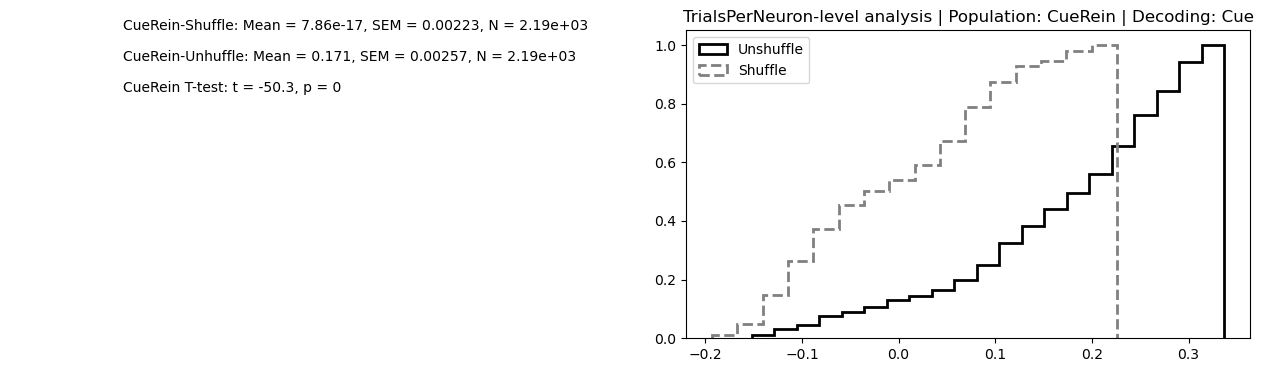

In [43]:
### DECODING CDF PLOTS FOR EARLY, MIDDLE, AND LATE DATA
population = 'CueRein'
variables_to_analyze = ['Cue']
groups = ['CueRein'] 
# color = (['k'],['tab:red'], ['tab:green'],['tab:blue'])
ls = ['--','solid']

d = {}
###THIS SECTION IS FOR LOADING AND PLOTTING SAVED POPULATION DECODING ARRAYS (BY NEURON OR SESSION)
for v, variable in enumerate (variables_to_analyze):
    d[variable] = {}
    all_shuffle_for_variable=[]
    fig, ax = plt.subplots(1, 2, figsize = (16,4))
    for g, group in enumerate(groups):
        d[variable][group] = {}
        d[variable][group] = np.array(np.load(os.path.join(decoding_dict_results_dir,
                                                           'PFC-HeroinSA_%s_%s_%s_Decoding-dict.npy'%(group,variable,decoding[0])), 
                                                           allow_pickle=True).astype(float))
        temp_unshuffle_nonans, temp_shuffle_nonans = ([],[])
        temp_unshuffle,temp_shuffle = (d[variable][group][0],d[variable][group][1])

        for i in range(len(temp_unshuffle)):
            if np.isfinite(temp_unshuffle[i]):
                temp_unshuffle_nonans = np.append(temp_unshuffle_nonans, temp_unshuffle[i])
        for i in range(len(temp_shuffle)):
            if np.isfinite(temp_shuffle[i]):
                temp_shuffle_nonans = np.append(temp_shuffle_nonans, temp_shuffle[i])
                
       ##NORMALIZING
        mean_shuffle = np.mean(temp_shuffle_nonans)
        temp_unshuffle_nonans = temp_unshuffle_nonans - mean_shuffle
        temp_shuffle_nonans = temp_shuffle_nonans - mean_shuffle

        plt.hist((temp_unshuffle_nonans),  density=True, cumulative=True,\
            label = 'Unshuffle', histtype='step',\
            linestyle = ('-'), bins = 'auto', color = 'k', linewidth=2)

        all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][group][1])
        if g == len(groups)-1:
            plt.hist((temp_shuffle_nonans),  density=True, cumulative=True,\
                label = 'Shuffle', histtype='step',\
                linestyle = ('--'), bins ='auto', color = 'grey', linewidth=2)
                
        ax[0].text(.2,1-g*.5,'%s-Shuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_shuffle_nonans)) + \
            ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_shuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_shuffle_nonans)))
        ax[0].text(.2, .9-g*.5,'%s-Unhuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_unshuffle_nonans)) + \
            ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_unshuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_unshuffle_nonans)))
        t, p = stats.ttest_ind(temp_shuffle_nonans,\
            temp_unshuffle_nonans, equal_var=False)
        ax[0].text(.2, .8-g*.5, '%s T-test: t = '%(group) + '{0:.3g}'.format(t) + ', p = ' + '{0:.3g}'.format(p))

    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)

    plt.legend(loc=2)
    plt.title('%s-level analysis | Population: %s | Decoding: %s'%(decoding[0], population, variable))
    
    # plt.savefig(os.path.join(decode_results_dir, 'PFC-HeroinSA_%s_%s_%s_Decoding.PDF'%(population, variable, decoding[0])), format = 'PDF')

    plt.show()

Group: CueRein


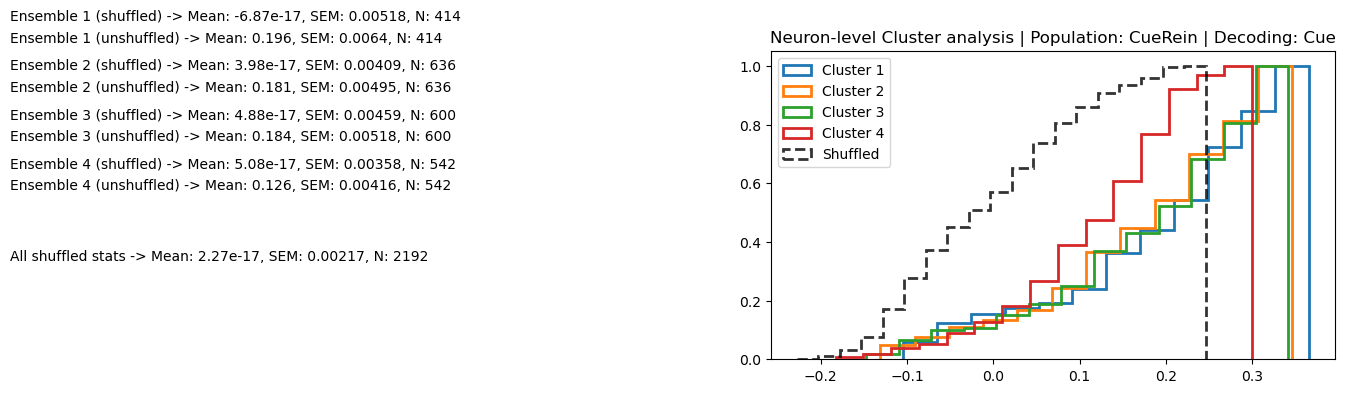

In [44]:
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)


### DECODING CDF PLOTS FOR EARLY, MIDDLE, AND LATE DATA
analyze_by = 'Neuron' ###Session or Neuron
variables_to_analyze = ['Cue']
groups = ['CueRein'] 
dir_list = [rst_cuedir]
color = (['k'],['tab:red'], ['tab:green'],['tab:blue'], ['tab:yellow'])
ls = ['--','solid']
bins = np.arange(0.4,0.8,0.01)  

for index in range(len(groups)):
    group = groups[index]
    newlabels = np.load((os.path.join(dir_list[index], 'cluster_list_per_session_CueDrugTMT.npy')))
    dict_file = np.load(os.path.join(decoding_dict_results_dir, 'PFC-HeroinSA_%s_%s_%s_Decoding-dict.npy'%(group, variables_to_analyze[0], decoding[0])),allow_pickle = True).astype(float)
    for variable in variables_to_analyze:
        print('Group:', group)
        d = {}
        d[variable]={}
        all_shuffle_for_variable = []
        fig, ax = plt.subplots(1, 2, figsize = (16,4))
        for cluster in range(numclusters):
            d[variable][cluster] = {}
            file_max = len(dict_file[1])
            fit = np.array(newlabels[:file_max])
            temp_array = np.squeeze(dict_file[:,np.where(fit==cluster)[0]])
            d[variable][cluster] = temp_array

            shuffled_mean = np.nanmean(d[variable][cluster][1])
            normalized_unshuffled = d[variable][cluster][0] - shuffled_mean
            normalized_shuffled = d[variable][cluster][1] - shuffled_mean
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, normalized_shuffled)

            plt.hist((normalized_unshuffled), density=True, cumulative=True,\
                                label = ['Cluster %s'%(cluster+1)], histtype='step', linestyle = '-',\
                                bins = 'auto', linewidth=2)
            ax[0].text(-0.15, (1.1-cluster*.16), 
                    ('Ensemble '+str(cluster+1)+' (shuffled) -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean((normalized_shuffled))) +
                    ', SEM: ' + '%.3g'%(stats.sem(normalized_shuffled[np.where(np.isfinite(normalized_shuffled))]))) +
                    ', N: ' + str(len(normalized_shuffled)))
            ax[0].text(-0.15, 1.03-cluster*.16, 
                    ('Ensemble '+str(cluster+1)+' (unshuffled) -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean((normalized_unshuffled))) +
                    ', SEM: ' + '%.3g'%(stats.sem(normalized_unshuffled[np.where(np.isfinite(normalized_unshuffled))]))) +
                    ', N: ' + str(len(normalized_unshuffled)))
            if cluster == len(uniquelabels)-1:
                plt.hist((all_shuffle_for_variable), density=True, cumulative=True,\
                    label = ['Shuffled'], histtype='step', linestyle = '--',\
                    bins = 'auto', linewidth=2, color = 'k', alpha = .8)
                ax[0].text(-0.15, .8-cluster*.16, 
                    ('All shuffled stats -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean(all_shuffle_for_variable)) +
                    ', SEM: ' + '%.3g'%(stats.sem(all_shuffle_for_variable[np.where(np.isfinite(all_shuffle_for_variable))]))) +
                    ', N: ' + str(len(all_shuffle_for_variable)))

            ax[0].get_xaxis().set_visible(False)
            ax[0].get_yaxis().set_visible(False)
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)
            ax[0].spines['left'].set_visible(False)
            ax[0].spines['bottom'].set_visible(False)

            plt.legend(loc=2)
            plt.title('%s-level Cluster analysis | Population: %s | Decoding: %s'%(analyze_by, population, variable))
        #change plot title as needed
        # plt.savefig(os.path.join(decode_results_dir, 'PFC-HeroinSA_%s_%s_%s_%s_Normalized-Cluster_Decoding.PDF'%(population, group, variable, analyze_by)), format = 'PDF')
        plt.show()

### Decoding: Neuron, Cue
Population: Acquisition
<br>Group(s): Early, Middle, and Late

In [ ]:
#initialize decoding directories
decoding_dict_results_dir =r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\cue-analysis\cue/results\decoding\dictionaries'%(user) #specify model type folder
decode_results_dir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\cue-analysis\cue/results\decoding'%(user)

#### Making dictionaries

In [ ]:
#creating dictionaries

groups = ['Early','Middle', 'Late']
indir_list = [acq_earlybasedir, acq_middlebasedir, acq_latebasedir]
animals_of_interest_list = [early_animals_of_interest, middle_animals_of_interest, late_animals_of_interest]
# groups = ['Early']
# indir_list = [acq_earlybasedir]
# animals_of_interest_list = [early_animals_of_interest]
session_analysis_split_by_ensemble = ['Yes'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['Neuron', 'Trial'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 4

#initialize epochs
baseline_epoch = [1, 8]
response_epoch = [pre_window_size, pre_window_size+12]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

print('========== STARTING ==========')
datadir=0
for index in range(len(groups)):
    group = groups[index]
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}

    animals_of_interest = animals_of_interest_list[index]
    indir = indir_list[index]

    numneuronstillnow = 0 
    for animal in animals_of_interest:
        print('Group:', group, '\nAnimal:', animal)
        fovs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(fovs):
            trials = np.load(os.path.join(indir, animal, fov, 'alignedActiveLeverCueData.npy'))
            flags = np.load(os.path.join(indir, animal, fov, 'classificationFlags.npy')) #flags should match num trials

            #eliminate NaN's
            for i in reversed(range(trials.shape[0])): ###reversed to prevent deletion from messing up indexing
                if np.isnan(np.mean(trials[i,:,:])):
                    trials = np.delete(trials, i, axis = 0)
                    flags = np.delete(flags, i)

            #references to shape
            num_trials = trials.shape[0]
            numneuronsinfov = trials.shape[2]

            if num_trials < 7:
                print('*** Error: insufficient trials ***')
            else:
                baseline = np.nan*np.ones((num_trials ,numneuronsinfov))
                response = np.nan*np.ones((num_trials, numneuronsinfov))

                #creating array of flags to classify predictions
                positives = len(flags[flags==1])
                negatives = len(flags[flags==0])
                activeflag = np.hstack((np.zeros((negatives)), np.ones((positives))))
                
                for neuron in range(numneuronsinfov):
                    baseline[:,neuron] = np.nanmean(trials[:,baseline_epoch[0]:baseline_epoch[1],neuron], axis=1)
                    response[:,neuron] = np.nanmean(trials[:,response_epoch[0]:response_epoch[1],neuron], axis=1)
                    neuralactivity_trialtype = np.vstack((baseline, response))

                    #assigning training data
                    y = activeflag
                    X = neuralactivity_trialtype[:,neuron] #y and X need to have matching shape values
                    try:
                        X = X.reshape(len(y), 2)
                    except:
                        X = np.expand_dims(X, axis=1)

                    #unshuffled data accuracy classifications
                    classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = binaryclassifier(y, X)
                    print('     Unshuffled accuracy:', classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron])
                    #shuffled data accuracy classifications
                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        new_y = np.random.permutation(activeflag) #shuffled flag
                        shuffledresults[shuffleid] = binaryclassifier(new_y, X)
                        print('     Shuffled accuracy:', shuffledresults[shuffleid])
                    classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = shuffledresults
                numneuronstillnow += numneuronsinfov
        print()
print('========== FINISHED ==========')

In [ ]:
#save dictionaries as .npy files
variable_to_save = 'Cue'
# groups = ['Early', 'Middle', 'Late']
groups = ['Early']
decoding_dict_results_dir =r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\cue-analysis\acquisition-reinstatement\results\decoding\dictionaries'%(user)

for g, group in enumerate (groups):
    try:
        unshuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['unshuffled'])), dtype=object)
        shuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['shuffled'])), dtype=object)
        stacked = np.vstack((unshuffled[:,1], shuffled[:,1]))
        np.save(os.path.join(decoding_dict_results_dir, 'PFC-HeroinSA_%s_%s_%s_Decoding-dict.npy'%(group,variable_to_save,decoding[0])),stacked)
    except Exception as e:
        print('*** Error:', e, '***')

#### .cdf plots

In [ ]:
#cdf plots for neurons

analyze_by = 'Neuron' ###Session or Neuron
population = 'Acquisition'
variables_to_analyze = ['Cue']
variable = 'Cue'
groups = ['Early', 'Middle', 'Late'] 
# groups = ['Early']
colors = (['k'],['tab:red'], ['tab:green'],['tab:blue'])
ls = ['--','solid']

d = {}
d[variable] = {}
all_shuffle_for_variable=[]
fig, ax = plt.subplots(1, 2, figsize = (16,4))
for g, group in enumerate(groups):
    d[variable][group] = {}
    d[variable][group] = np.array(np.load(os.path.join(decoding_dict_results_dir,
                                                        'PFC-HeroinSA_%s_%s_%s_Decoding-dict.npy'%(group,variable,analyze_by)), 
                                                        allow_pickle = True).astype(float))
    temp_unshuffle_nonans, temp_shuffle_nonans = ([],[])
    temp_unshuffle,temp_shuffle = (d[variable][group][0],d[variable][group][1])

    for i in range(len(temp_unshuffle)):
        if np.isfinite(temp_unshuffle[i]):
            temp_unshuffle_nonans = np.append(temp_unshuffle_nonans, temp_unshuffle[i])
    for i in range(len(temp_shuffle)):
        if np.isfinite(temp_shuffle[i]):
            temp_shuffle_nonans = np.append(temp_shuffle_nonans, temp_shuffle[i])
            
    #normalize data
    mean_shuffle = np.mean(temp_shuffle_nonans)
    temp_unshuffle_nonans = temp_unshuffle_nonans - mean_shuffle
    temp_shuffle_nonans = temp_shuffle_nonans - mean_shuffle
    
    plt.hist((temp_unshuffle_nonans),  density=True, cumulative=True,\
        label = '%s-Unshuffle'%(group), histtype='step',\
        linestyle = ('-'), bins = 'auto', color = colors[g], linewidth=2)

    all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][group][1])
    if g == len(groups)-1:
        plt.hist((temp_shuffle_nonans),  density=True, cumulative=True,\
            label = 'Shuffle', histtype='step',\
            linestyle = ('--'), bins ='auto', color = 'k', alpha=.8,linewidth=2)
            
    ax[0].text(.2,1-g*.5,'%s-Shuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_shuffle_nonans)) + \
        ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_shuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_shuffle_nonans)))
    ax[0].text(.2, .9-g*.5,'%s-Unhuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_unshuffle_nonans)) + \
        ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_unshuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_unshuffle_nonans)))
    t, p = stats.ttest_ind(temp_shuffle_nonans,\
        temp_unshuffle_nonans, equal_var=False)
    ax[0].text(.2, .8-g*.5, '%s T-test: t = '%(group) + '{0:.3g}'.format(t) + ', p = ' + '{0:.3g}'.format(p))

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

plt.legend(loc=2)
plt.title('%s-level analysis | Population: %s | Decoding: %s'%(analyze_by, population, variable))

plt.savefig(os.path.join(decode_results_dir, 'PFC-HeroinSA_%s_%s_%s_Decoding.PDF'%(population, variable, analyze_by)), format = 'PDF')

plt.show()

In [ ]:
#cdf plots for clusters

analyze_by = 'Neuron' ###Session or Neuron
variables_to_analyze = ['Cue']
groups = ['Early', 'Middle', 'Late'] 
dir_list = [acq_earlybasedir, acq_middlebasedir, acq_latebasedir]
color = (['k'],['tab:red'], ['tab:green'],['tab:blue'], ['tab:yellow'])
ls = ['--','solid']
bins = np.arange(0.4,0.8,0.01)  

for index in range(len(groups)):
    group = groups[index]
    newlabels = np.load((os.path.join(dir_list[index], 'cluster_list_per_session_Acquisition.npy')))
    dict_file = np.load(os.path.join(decoding_dict_results_dir, 'PFC-HeroinSA_%s_%s_%s_Decoding-dict.npy'%(group, variables_to_analyze[0], analyze_by)),allow_pickle = True).astype(float)
    for variable in variables_to_analyze:
        print('Group:', group)
        d = {}
        d[variable]={}
        all_shuffle_for_variable = []
        fig, ax = plt.subplots(1, 2, figsize = (16,4))
        for cluster in range(numclusters):
            d[variable][cluster] = {}
            file_max = len(dict_file[1])
            fit = np.array(newlabels[:file_max])
            temp_array = np.squeeze(dict_file[:,np.where(fit==cluster)[0]])
            d[variable][cluster] = temp_array

            shuffled_mean = np.nanmean(d[variable][cluster][1])
            normalized_unshuffled = d[variable][cluster][0] - shuffled_mean
            normalized_shuffled = d[variable][cluster][1] - shuffled_mean
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, normalized_shuffled)

            plt.hist((normalized_unshuffled), density=True, cumulative=True,\
                                label = ['Cluster %s'%(cluster+1)], histtype='step', linestyle = '-',\
                                bins = 'auto', linewidth=2)
            ax[0].text(-0.15, (1.1-cluster*.16), 
                    ('Ensemble '+str(cluster+1)+' (shuffled) -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean((normalized_shuffled))) +
                    ', SEM: ' + '%.3g'%(stats.sem(normalized_shuffled[np.where(np.isfinite(normalized_shuffled))]))) +
                    ', N: ' + str(len(normalized_shuffled)))
            ax[0].text(-0.15, 1.03-cluster*.16, 
                    ('Ensemble '+str(cluster+1)+' (unshuffled) -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean((normalized_unshuffled))) +
                    ', SEM: ' + '%.3g'%(stats.sem(normalized_unshuffled[np.where(np.isfinite(normalized_unshuffled))]))) +
                    ', N: ' + str(len(normalized_unshuffled)))
            if cluster == len(uniquelabels)-1:
                plt.hist((all_shuffle_for_variable), density=True, cumulative=True,\
                    label = ['Shuffled'], histtype='step', linestyle = '--',\
                    bins = 'auto', linewidth=2, color = 'k', alpha = .8)
                ax[0].text(-0.15, .8-cluster*.16, 
                    ('All shuffled stats -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean(all_shuffle_for_variable)) +
                    ', SEM: ' + '%.3g'%(stats.sem(all_shuffle_for_variable[np.where(np.isfinite(all_shuffle_for_variable))]))) +
                    ', N: ' + str(len(all_shuffle_for_variable)))

            ax[0].get_xaxis().set_visible(False)
            ax[0].get_yaxis().set_visible(False)
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)
            ax[0].spines['left'].set_visible(False)
            ax[0].spines['bottom'].set_visible(False)

            plt.legend(loc=2)
            plt.title('%s-level Cluster analysis | Population: %s | Decoding: %s'%(analyze_by, population, variable))
        plt.savefig(os.path.join(decode_results_dir, 'PFC-HeroinSA_%s_%s_%s_%s_Normalized-Cluster_Decoding.PDF'%(population, group, variable, analyze_by)), format = 'PDF')
        plt.show()